In [20]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras import backend as Keras

### Mine Triplets

In [2]:
CAFFE_ROOT = '/home/albert/caffe/'
img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')

In [3]:
train_files = {}
labels = []

for f in img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in labels):
            labels.append(idt)
            train_files[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files[idt].append(path)

labels.sort()

In [101]:
def batch_generator(train_files, labels, P=18, K=4):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
#             batch.append([])
            k_choice = np.random.choice(range(len(train_files[idt_choice[p]])), K, replace=False)
            for k in k_choice:
                path = train_files[idt_choice[p]][k]
                img = cv2.resize(misc.imread(path), (224, 224))
                batch.append(img.tolist())
        yield(batch)

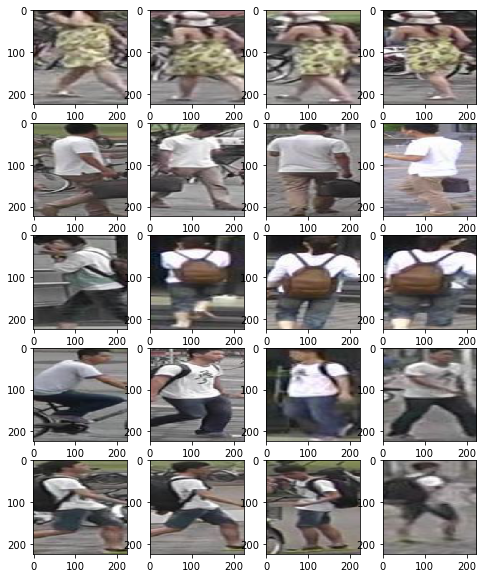

In [102]:
generator = batch_generator(train_files, labels)
batch = generator.next()
batch = np.array(batch, dtype=np.uint8)

plt.figure(figsize=(8,10))
t = 0
for idt in range(20):
    t += 1
    plt.subplot(5, 4, t)
    plt.imshow(batch[idt])
plt.show()

### Train Network

In [8]:
model = ResNet50(weights='imagenet', include_top=False)

In [73]:
def output_batch_generator(train_files, labels, P=18, K=4):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
            # n_choose = np.minimum(K, len(train_files[idt_choice[p]]))
            k_choice = np.random.choice(range(len(train_files[idt_choice[p]])), K, replace=True)
            for k in k_choice:
                path = train_files[idt_choice[p]][k]
                img = cv2.resize(misc.imread(path), (224, 224))
                batch.append(img.tolist())
        output = model.predict_on_batch(batch)
        yield(output, np.zeros((output.shape[0], output.shape[1], output.shape[2], 1)))

In [74]:
output_generator = output_batch_generator(train_files, labels)

In [75]:
output_batch = output_generator.next()

In [84]:
print(output_batch[0].shape)

(72, 1, 1, 2048)


In [77]:
trinet = Sequential()
trinet.add(Dense(1024, input_shape=(1, 1, 2048)))
trinet.add(BatchNormalization())
trinet.add(Activation('relu'))
trinet.add(Dense(128))

In [78]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

In [79]:
def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2))

In [99]:
def triplet_loss(y_true, y_pred, margin=0.1, P=18, K=4, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += margin + hard_pos - hard_neg
    return loss

In [96]:
trinet.compile(loss=triplet_loss, optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [97]:
trinet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1, 1, 1024)        2098176   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 1, 1024)        4096      
_________________________________________________________________
activation_53 (Activation)   (None, 1, 1, 1024)        0         
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1, 128)         131200    
Total params: 2,233,472
Trainable params: 2,231,424
Non-trainable params: 2,048
_________________________________________________________________


In [100]:
trinet.fit_generator(output_batch_generator(train_files, labels), steps_per_epoch=5, epochs=10)

Epoch 1/10
5/5 [==============================] - 107s - loss: -1521009.5750    
Epoch 2/10
5/5 [==============================] - 97s - loss: -1934375.8750     
Epoch 3/10
5/5 [==============================] - 104s - loss: -2380944.1000    
Epoch 4/10
5/5 [==============================] - 96s - loss: -2863843.8000     
Epoch 5/10
5/5 [==============================] - 98s - loss: -3439037.5000     
Epoch 6/10
5/5 [==============================] - 118s - loss: -4097320.0000    
Epoch 7/10
5/5 [==============================] - 100s - loss: -4683844.2000    
Epoch 8/10
5/5 [==============================] - 102s - loss: -5480526.6000    
Epoch 9/10
5/5 [==============================] - 98s - loss: -6148190.3000     
Epoch 10/10
5/5 [==============================] - 97s - loss: -7012410.5000     


In [36]:
np.minimum(1,2)

1

In [61]:
np.random.choice(range(5), 10, replace=True)

array([2, 1, 3, 0, 1, 4, 1, 4, 0, 1])

In [86]:
loss = tf.Variable(1, dtype=tf.float32)
print(loss)

<tf.Variable 'Variable_1:0' shape=() dtype=float32_ref>
